In [1]:
import      numpy               as      np
import      matplotlib.pyplot   as      plt
from        lib_Experimentum    import  *
from        Alessandria         import  *


#path dove stanno i dati del fit
now_path        =   '../BRILLOUIN/TDP43/NO_ARS_12_02/analysis_new_cut_best/'

### recupero info su dimensionalità
spectra_path = '../BRILLOUIN/TDP43/NO_ARS_12_02/'
spectra_filename    =   'NO_ARS_12_02'
n_rows    =   len(Import_from_Matlab(spectra_filename, spectra_path, var_name = 'y3'))
n_cols  =   len(Import_from_Matlab(spectra_filename, spectra_path, var_name = 'y3')[0])
###
matrix, rows, cols = Initialize_Matrix(0,0,n_rows,n_cols)

Ho inizializzato una matrice 101x83, per un totale di 8383 spettri


In [2]:

#1) Recupero info su posizioni + info su chi è bono e chi no e su VIPA (questo solo per matrix[0][0])

with open(now_path+'xy.txt', 'r') as fin:
    lines = fin.readlines()[1:]

excluded = ()

with open(now_path+'markov_fit.txt', 'r') as fin:
    fit     =   eval(fin.read())
_,_,_, boni = Unpack_Fit(fit)

"""
with open(now_path+'xy_VIPA.txt', 'r') as fin:
    VIPAs = fin.readlines()[1:]

x_VIPA = np.array(VIPAs[0][1:-2].split(), dtype=float)
y_VIPA = np.array(VIPAs[1][1:-2].split(), dtype=float)

matrix[0][0].Recover_VIPA(x_VIPA, y_VIPA)
"""
count = 0
for ii in range(len(rows)):
    for jj in range(len(cols)):
        #print(str((ii,jj)))
        matrix[ii][jj].Recover_Spectrum(np.array(lines[count][1:-2].split(), dtype=float), np.array(lines[count+1][1:-2].split(), dtype=float))
        
        if (ii,jj) not in boni:
            excluded = excluded +((ii,jj),)

        count = count + 2

print('Ok ho recuperato le informazioni sulle posizioni')

Ok ho recuperato le informazioni sulle posizioni


In [40]:
#2) Acquisico i dati prodotti dal fit markoviano


##################### MARKOVIANO

with open(now_path+'y_markov_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_markov.txt', 'r') as fin:
    costi = fin.readlines()

with open(now_path+'markov_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza boni ({}) e informazioni parametri fit ({})".format(len(boni), len(lines)))
if (len(boni) != len(costi)):
    raise ValueError("Incompatibilità tra lunghezza boni ({}) e informazioni costo fit ({})".format(len(boni), len(costi)))
"""
if (len(boni) != len(y_fits)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e y fit ({})".format(len(boni), len(y_fits)))
"""

#for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
for (line, cost, (ii,jj)) in zip(lines, costi,   boni) :
    matrix[ii][jj].Recover_Markov_Fit_Params(line)
    #matrix[ii][jj].Recover_y_markov_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_markov(float(cost))

print('Ok ho recuperato le informazioni del Fit Markoviano')




Ok ho recuperato le informazioni del Fit Markoviano


In [41]:
matrix[100][0].Markov_Fit_Params

,Co,Omega,Gamma,delta_position,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,0.103614,7.428017,0.121461,1.919218,0.032536,4.123157,4.981388e+03,-7.184732,15.447074,0.093908,6.824871
StdErrs,0.144066,0.017017,0.011955,0.001332,0.004962,0.921097,6.325439e+09,31.913324,30.506826,0.016673,1.123782
Initials,0.102576,7.429282,0.136461,1.919156,0.034299,4.188016,4.151157e+03,-7.113596,15.431642,0.084684,6.176627


In [4]:
#Parametri di Interesse per analisi

too_bad = ()
too_good  = ()
omega_too_high =  ()
gamma_too_bad = ()
omega_max = 8.2
gamma_max = 0.35
cost_max = 1000
cost_min = 50

print('Ho trovato per i dati in {} :\n'.format(now_path))


too_bad = Get_Bad_Elements(matrix, boni, cost_max)
too_good = Get_Good_Elements(matrix, boni, cost_min)
omega_too_high = Whose_Param_Too_High('Omega', omega_max, 'markov', matrix, boni)
gamma_too_high = Whose_Param_Too_High('Gamma', gamma_max, 'markov', matrix, boni)

print('{} elementi con Omega > {}\n'.format(len(omega_too_high), omega_max))
print('{} elementi con Gamma > {} \n'.format(len(gamma_too_high), gamma_max))

#aggiunte 
too_bad_gamma = ()
too_offset = ()
percentage_gamma = 15
max_offset = 30
almost_height = ()

for (ii,jj) in boni:
    if matrix[ii][jj].Markov_Fit_Params.T.StdErrs['Gamma'] > (matrix[ii][jj].Markov_Fit_Params.T.Values['Gamma']*(percentage_gamma/100)):
        too_bad_gamma += ((ii,jj),)
    if matrix[ii][jj].Markov_Fit_Params['offset'].values[0] > max_offset:
        too_offset += ((ii,jj),)
    if matrix[ii][jj].y.max() > 15000:
        almost_height += ((ii,jj),)

print('{} elementi con Gamma con errore > {} \n'.format(len(gamma_too_bad), percentage_gamma))
print('{} elementi con offset > {} \n'.format(len(too_offset), max_offset))





Ho trovato per i dati in ../BRILLOUIN/TDP43/NO_ARS_12_02/analysis_new_cut_best/ :



AttributeError: 'Spectrum' object has no attribute 'cost_markov'

In [5]:
#HISTOGRAMs
plt.figure()
plt.title('Omega distribution over sample')
_ = plt.hist([matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] for (ii,jj) in boni], bins = 50, label = 'omega',histtype = 'bar', stacked = True, rwidth= 0.8,  color = 'royalblue')
plt.legend()
plt.show()
plt.close()
plt.figure()
plt.title('Gamma distribution over sample')
_ = plt.hist([matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] for (ii,jj) in boni], bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8,  color = 'maroon')
plt.legend()
plt.show()
plt.close()

AttributeError: 'Spectrum' object has no attribute 'Markov_Fit_Params'

In [6]:
#MAPPE
omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 7.35, 8., fig = 'omega_markov_map', path=now_path)
Delta_omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 0,10, fig = 'Delta_omega_markov_map', path=now_path, Deltas = True)
gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0.1,0.23, fig = 'Gamma_markov_map', path=now_path)
Delta_gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 3, 15, fig = 'Delta_Gamma_markov_map', path=now_path, Deltas = True)
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)

AttributeError: 'Spectrum' object has no attribute 'Markov_Fit_Params'

In [7]:
Plot_Elements_Spectrum(matrix, boni[0:10], fit = 'markov')

(0, 82)


ValueError: x and y must have same first dimension, but have shapes (106,) and (135,)

In [8]:
matrix[17][33].Markov_Fit_Params.values[0]

array([ 1.09874084e-01,  7.65204414e+00,  1.57627659e-01,  5.41712628e-01,
        1.23004708e-01,  6.02327083e+01,  9.90343834e+02, -7.46476990e+00,
        1.54265767e+01,  2.82536012e-01,  1.56550907e+01])

In [9]:
plt.figure()
x = np.linspace(-40, 10, 5000)
for (ii,jj) in boni[-1:]:
    plt.plot(x, gaussian(x, 1000, *matrix[ii][jj].Markov_Fit_Params[list(cols_gauss)].values[0][1:]), c = 'r')
    plt.show()
matrix[ii][jj].Markov_Fit_Params[['mu', 'sigma']]


AttributeError: 'Spectrum' object has no attribute 'Markov_Fit_Params'

In [10]:
################ TOTALE

with open(now_path+'y_tot_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_tot.txt', 'r') as fin:
    costi = fin.readlines()
with open(now_path+'tot_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e informazioni fit ({})".format(len(boni), len(lines)))

for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,  boni) :
    matrix[ii][jj].Recover_Tot_Fit_Params(line)
    matrix[ii][jj].Recover_y_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_tot(float(cost))

print('Ok ho recuperato le informazioni del Fit Totale')

Ok ho recuperato le informazioni del Fit Totale


Completata Parameter_Map per Omega
Ho trovato 66 elementi saturati


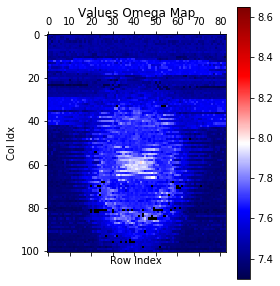

Completata Parameter_Map per Omega
Ho trovato 66 elementi saturati


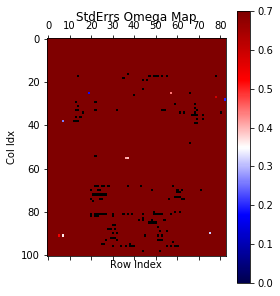

Completata Parameter_Map per Gamma
Ho trovato 66 elementi saturati


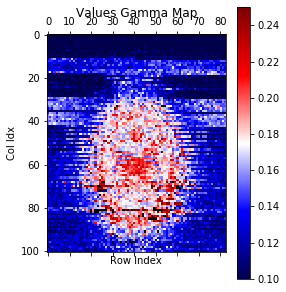

Completata Parameter_Map per Gamma
Ho trovato 66 elementi saturati


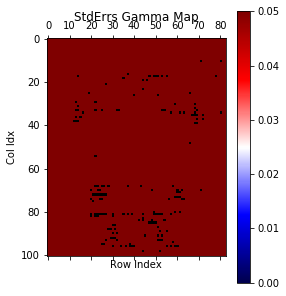

Completata Parameter_Map per tau
Ho trovato 66 elementi saturati


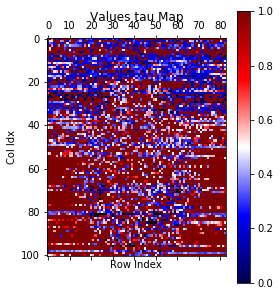

Completata Parameter_Map per tau
Ho trovato 66 elementi saturati


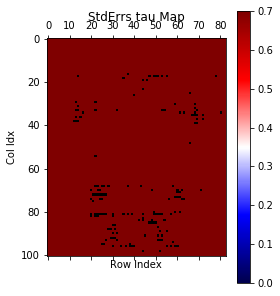

In [11]:
omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded, 'seismic', 7.3, 8.65, fig = 'omega_tot_map', path=now_path)
Delta_omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded, 'seismic', 0,0.7, fig = 'Delta_omega_tot_map', path=now_path, Deltas = True)
gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded, 'seismic', 0.1,0.25, fig = 'Gamma_tot_map', path=now_path)
Delta_gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded, 'seismic', 0,0.05, fig = 'Delta_gamma_tot_map', path=now_path, Deltas = True)
tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'seismic', 0., 1., fig = 'tau_map', path=now_path)
Delta_tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'seismic', 0,0.7, fig = 'Delta_tau_map', path=now_path, Deltas = True)

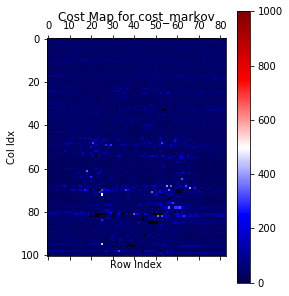

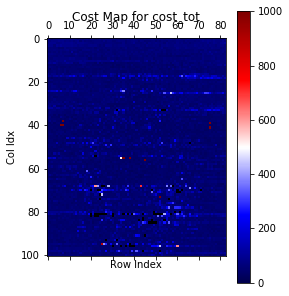

In [12]:
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)
tot_cost_map = Get_cost_map(matrix, 'tot', len(rows), len(cols), 'tot_cost_map', path = now_path)


In [13]:
Plot_Elements_Spectrum(matrix, boni[0:20], fit = 'markov')

(0, 82)


ValueError: x and y must have same first dimension, but have shapes (106,) and (135,)

In [14]:
for (ii,jj) in boni[0:20]:
    print(matrix[ii][jj].Markov_Fit_Params)


Co     Omega     Gamma  delta_position  delta_width  \
Values    0.099908  7.454707  0.101961        0.209999     0.034045   
StdErrs   0.303618  0.024485  0.010949        0.001521     0.004131   
Initials  0.107378  7.571486  0.149129        0.119016     0.144893   

          delta_amplitude             A         mu      sigma     shift  \
Values           2.618701  5.569801e+03  -9.989592  15.784915  0.145455   
StdErrs          1.605161  9.261726e+09  47.211715  71.046653  0.017827   
Initials         8.346143  4.797472e+03 -10.090497  15.800716  0.211020   

            offset  
Values    2.248037  
StdErrs   4.365106  
Initials -0.310388  
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.094995  7.498207  0.047434        0.210478     0.035508   
StdErrs   0.257239  0.024337  0.009431        0.002120     0.005970   
Initials  0.099908  7.454707  0.101961        0.209999     0.034045   

          delta_amplitude             A         mu      sigma